# Description

Соревнование 2. Подсчет квадратов на изображении  
Условия  
Описание задачи  
В вашем распоряжении есть набор изображений, которые состоят из нескольких видов геометрических фигур:  

- квадратов;  
- прямоугольников;  
- параллелограммов;  
- окружностей.  
Ваша задача – посчитать количество квадратов на каждом изображении из тестовых данных. Изображения для обучения можно скачать здесь.  

Описание данных  
Весь набор данных состоит из 3 типов изображений в равном количестве:  

Содержат только квадраты, которые могут иметь общие стороны, вкладываться друг в друга, но не пересекаться.  
Содержат квадраты и другие фигуры, все они могут иметь общие стороны, вкладываться друг в друга, но не пересекаться.  
Содержат квадраты и другие фигуры, которые дополнительно могут пересекаться.  
Ниже находятся 2 файла, которые потребуются для решения задачи: train.csv – содержит информацию об изображениях для обучения, test.csv – содержит информацию об изображениях для теста. Имеют поля:  

- img_path – путь до изображения  
- label – число квадратов на изображении (только в обучающем наборе)  
- type – тип изображения 1/2/3 (только в обучающем наборе)  
Пример сабмита можно посмотреть в файле sample_submission.csv. Он содержит одну колонку label, порядок соответсвует порядку данных в тестовом наборе.  

Метрика качества  
В качесте метрики качества используется метрика Root Mean Square Error (RMSE)  

ссылка на скачивание датасетов: https://drive.google.com/drive/folders/1obvLC3Gbu1XSOu75ThRaf7rBEYdWJnq4?usp=sharing

# General solution description

Для решения применил библиотеку openCV для распознавания квадратов. Описание решения с помощью ML смотри ниже.  

Так как фигуры на всех изображениях однотонны и в большинстве случаев имеют отличные друг от друга цвета, то можно поочередно убирать все цвета, оставляя только один. Данное изображение анализируется с помощью инструментов openCV и получаем есть ли на данном изображении квадрат и в каком количестве. После этого оставляем другой цвет, остальные "закрашиваем" и считаем квадраты. Так проходим по всем уникальным цветам на изображении и суммируем значения количества квадратов на каждом шаге.  

Инструменты openCV, по которым определялось квадрат ли на изображении:
 - определение контуров с помощью findContours
 - у контуров определелось - если 4 грани равные и косинус угла между ними = 0 (±0.1) то это квадрат
Однако этих условий не достаточно на случай, когда при "затирании" пересекующихся фигур, или фигур с единой гранью, часть грани квадрата тоже затирается. В таких случаях применялись дополнительные проверки:
 - проверка на равность сторон не по длине граней, а по крайним координатам
 - "утолщение" линий фигур с помощью dialate
 - сдвиг фигуры в центр
 - оценка не самой фигуры, а ее bounding bounds
 
У работы с контурами openCV есть недостаток, что метод возвращает не один объект на каждую фигуру, а сразу несколько похожих, как бы обводя фигуру несколько раз. Для исключения пришлось написать функцию убирающую лишние контуры после проверки, что контур на несколько пикселей совпадает с другими. Кроме этого метод возвращает и и контур всего изображения. Его тоже пришлось вычитать.

Кроме этого было замечено, что изображения  разных типов (1,2 или 3) могут чуть лучше предсказываться изменяя параметры обработки изображений. Например изображения типа 1 лучше определяются вообще без dialation, а изображения типа 3 лучше определяются с утолщением и сдвигом в центр. Для того, чтобы применять к каждому типу изображения свои параметры, была обучена классифицирующая сеть. При прогнозе этой сети что то или иное изображение относится к какму-то классу, выбирались соответствующие параметры. Так удалось снизить ошибку на 0.04.

В качестве результата удалось добиться показателя rmse на тестовом наборе 6000 штук 0.4127145906474998 на публичной части и 0.42504901678120216 на приватной части, что является достаточно хорошим показателем



PS: гипотеза по решению с помощью ML:   
при попытке обучить регрессионную нейронную сеть, подавая на вход изображения, получая на выходе прогноз количества квадратов, была получена очень высокая ошибка (в районе RMSE 1.5).  
Анализ тестовой и обучающей выборок показал, чтов обучающей выборке на каждой картинке не более 10 квадратов, а в тестовой количество квадратов значительно больше и доходит до 20. Таким образом при обучении на наборе с небольшим количестовм квардратов, модель крайне плохо предсказывает количество на картинках, где квадратов больше 10 - для нее это выброс.  
Поэтому есть гипотеза, что необходимо догенерировать обучающий набор с большим количеством квадратов (либо самостоятельно, либо объединяя картинки из текущего набора), обучить сеть на общем наборе, и тогда ошибка будет в пределах допустимого (прогнозно rmse 0.5-0.6). КРоме этого в модель вместе с картинками можно подавать и тип изображения: 1,2 или 3. 

# Import

In [9]:
from datetime import datetime

import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
from itertools import combinations

import multiprocessing

# EDA

In [10]:
train = pd.read_csv('train.csv')
train

,img_path,label,type
0,train_data/1.png,3,1
1,train_data/2.png,7,3
2,train_data/3.png,9,2
3,train_data/4.png,9,1
4,train_data/5.png,10,1
...,...,...,...
2995,train_data/2996.png,10,1
2996,train_data/2997.png,2,1
2997,train_data/2998.png,7,1
2998,train_data/2999.png,7,3


In [11]:
test = pd.read_csv('test.csv')
test

,img_path
0,test_data/1.png
1,test_data/2.png
2,test_data/3.png
3,test_data/4.png
4,test_data/5.png
...,...
5995,test_data/5996.png
5996,test_data/5997.png
5997,test_data/5998.png
5998,test_data/5999.png


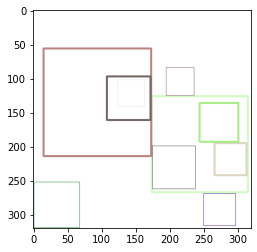

In [12]:
# откроем пример изображения
filename = '111.png' # Имя файла
image = Image.open('train_data/'+filename)
im_arr = np.array(image)
img1 = ImageDraw.Draw(image) 
plt.imshow(image) # Рисуем изображение

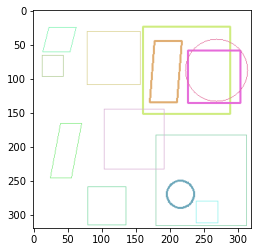

In [8]:
# откроем пример изображения
filename = '6.png' # Имя файла
image = Image.open('train_data/'+filename)
im_arr = np.array(image)
img1 = ImageDraw.Draw(image) 
plt.imshow(image) # Рисуем изображение

# Functions

Определим функции, с помощью которых будем обрабатывать изображения и подсчитывать квадраты

In [52]:
# определим основные параметры
bord = 3                   # количество пикселей в рамках сдвига, когда мы считаем два контура - контурами одной и той же фигуры
bord_square = 2            # количество пикселей, в рамках которым мы считаем отклонение от квадрата допустимым
big_bord = 3               # количество пикселей, представляющее сдвиг от внешних груниц изображение. В рамках этого количества будем считать определнный контур как ложноопределенный

out_bord_min = 10          #  минимальное приближение фигуры к границе, когда необходмио сделать сдвиг в центр
out_bord_max = 310         #  макскимальное приближение фигуры к границе, когда необходимо сделать сдвиг в центр

roll_to_center = 20        #  на сколько пикселей сдвигаем в центр

its = 1                    #  сколько итераций dialate нужно сделать
its_size = (2,2)           #  размер dialate

In [53]:
def preproccess_image(img):
    """
    Предобработка изображения перед подсчетом квадратов
    """
#     инвертируем изображение
    img = img - 255

#     сдвигаем изобржение ближе к центру, если оно находится на границе
    if img[img!=[0,0,0]].shape[0]>0:
        min_0 = np.where(img!=[0,0,0])[0].min()
        min_1 = np.where(img!=[0,0,0])[1].min()
        max_0 = np.where(img!=[0,0,0])[0].max()
        max_1 = np.where(img!=[0,0,0])[1].max()

        if min_0 < out_bord_min:
            img = np.roll(img, roll_to_center, axis=0)
        if min_1 < out_bord_min:
            img = np.roll(img, roll_to_center, axis=1)
        if max_0 > out_bord_max:
            img = np.roll(img, -1 * roll_to_center, axis=0)
        if max_1 > out_bord_max:
            img = np.roll(img, --1 * roll_to_center, axis=1)

#     делаем контуры толще        
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, its_size)
    img = cv.dilate(img, kernel, iterations=its)
    
    return img

In [15]:

pick_shape = im_arr.shape
def is_same(a, b, bord):
    """определяет является ли пара контуров контурами вокруг одной и той же фигуры"""
    a = a[a[:, 1].argsort()]
    b = b[b[:, 1].argsort()]
    
    return abs(np.sum(a[:,0]-b[:,0])) < bord and abs(np.sum(a[:,1]-b[:,1])) < bord
    
def is_square(arr):
    """определяет квадрат ли фигура по его крайним координатам"""
    size1 = abs(arr[:,0].max() - arr[:,0].min())
    size2 = abs(arr[:,1].max() - arr[:,1].min())
    
    if size1 > pick_shape[0] - big_bord and size2 > pick_shape[0] - big_bord:
        return False
    return abs(size1 - size2) < bord_square and ((abs(arr[0,0] - arr[3,0])<bord_square and  abs(arr[1,0] - arr[2,0])<bord_square) or
                                                (abs(arr[0,0] - arr[2,0])<bord_square and  abs(arr[1,0] - arr[3,0])<bord_square) or
                                                (abs(arr[0,0] - arr[1,0])<bord_square and  abs(arr[2,0] - arr[3,0])<bord_square))
        

    


In [16]:
def count_sq(row, bord=10):
    """
    подсчитывает количество квадратов на изображении.
    В цикле перебираются все уникальные цвета на изображении, в каждой итерации оставляется один цвет, остальные закрашиваются 
    под цвет фона.
    После того как получаются значения контуров квадратов, они попарно сравниваются, чтобы исключить когда несколько контуров "рисуются"
    вокруг одного и того же квадрата
    """
    print(row)
    filename = row
    img = cv.imread(filename, 1)

    res_cnt = 0
    
    im_arr = np.array(img)
    
    for color in np.unique(im_arr.reshape([320*320,3]), axis=0):

        mask = ((im_arr[:,:,0] == color[0]) &
                (im_arr[:,:,1] == color[1]) &
                (im_arr[:,:,2] == color[2]))
        im_to_show = im_arr.copy()
        im_to_show[~mask] = [255,255,255]

        im_to_show = preproccess_image(im_to_show)
        sq = np.array(find_squares(im_to_show))

        for i in range(sq.shape[0]):
            for j in range(i+1, sq.shape[0]):
                if is_same(sq[i], sq[j], bord):
                    sq[j] = sq[i]

        un = np.unique(sq, axis=0)
        un_cnt = un.shape[0]

        for last in un:
            if not is_square(last):
                un_cnt -= 1
        res_cnt +=   un_cnt   

    return res_cnt

In [17]:
def angle_cos(p0, p1, p2):
    """Определяет косинул угла между гранями контура по трем точкам"""
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def bb_to_cont(bb):
    """Трансформирует bounding border, который определн по двум крайним точкам в формат конутра, когда указываются координаты 4х точек"""
    bb_new = np.array([
        [bb[0], bb[1]],
        [bb[0], bb[1]+bb[3]-1],
        [bb[0]+bb[2]-1, bb[1]+bb[3]-1],
        [bb[0]+bb[2]-1, bb[1]]
    ])
    return bb_new

bord_inner = 1
def is_same_inner(a, b, bord):
    """Проверяет совпадает ли bounding border с найденным контуром"""
    for comb in combinations(a, 4):
        a_new = np.array(comb)
        if abs(np.sum(a_new[:,0]-b[:,0])) < bord and abs(np.sum(a_new[:,1]-b[:,1])) < bord:
            return True

    return False

def find_squares(img):
    """
    находит квадраты на изображении по контурам
    """
    img = cv.GaussianBlur(img, (5, 5), 0)
    squares = []
#     находим контуры
    for gray in cv.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)  
            for cnt in contours:
                flag = 0

                cnt_len = cv.arcLength(cnt, True)
                cnt2 = cv.approxPolyDP(cnt, 0.1*cnt_len, True)
#                 считаем количество граней контура и его площадь
                if cnt_len > 120:
                    
                    if len(cnt) == 4 and cv.contourArea(cnt2) > 100 and cv.isContourConvex(cnt2):
                        
                        cnt2 = cnt2.reshape(-1, 2)
#                         считаем косинусы углов между гранями контура. Если макимальный косинус около нуля то считаем фигуру квадратом
                        max_cos = np.max([angle_cos( cnt2[i], cnt2[(i+1) % 4], cnt2[(i+2) % 4] ) for i in range(4)])
                        if max_cos < 0.1:
                            squares.append(cnt2)
#                     отдельно обработаем контуры у которых больше 4х граней. Квдараты с общей гранью после затирания одного из них могли потерять часть грани
#                     в таком случае условие на 4 грани не будет соблюдаться
#                     Будем использовать не контур а bounding border вокруг фигуры.
#                     если bb квадратный и угулы совпадают с конутром фигуры, то считаем саму фигуру за квадрат
                    elif len(cnt) < 50 and len(cnt) >4 :
                        bb =  bb_to_cont(cv.boundingRect(cnt))
                        if cv.contourArea(bb) > 1000:
                            cnt_copy = cnt.reshape(-1, 2)
                            cos_list = [angle_cos( cnt_copy[i], cnt_copy[(i+1) % 4], cnt_copy[(i+2) % 4] ) for i in range(2)]
                            for cos_item in cos_list:
                                if cos_item < 0.1:
                                    if is_same_inner(cnt_copy, bb, bord_inner):
                                        squares.append(bb)
                                        flag = 1
                                        continue
                            if flag:
                                continue

    return squares

In [18]:
def rmse(df):
    """подсчет ошибки rmse по датасету"""
    rmse = (np.sum((df['label'] - df['pred']) ** 2) / df.shape[0]) ** (0.5)
    print('rmse - ', rmse)
    return rmse
    

In [19]:
def pred_to_csv(pred):
    """сохраняем датасет в cvs  в подходящий для контеста формат"""
    pred.rename(columns={'pred': 'label'}, inplace=True)
    pred = pred[['label']]

    pred.to_csv(f'./predictions/predict_{datetime.now()}.csv', index=False)

In [20]:
def stat(df, train=True):
    """Печатает статистику по датасету, включая разбивку по разным типам"""
    if train:
        print('rmse всего =')
        rmse(df)
    print(df.describe())
    
    if train:
        print(pd.concat((df.groupby('label')['label'].value_counts(), df.groupby('pred')['pred'].value_counts()),axis=1))
        for i in range(1,4):
            print('---------------')
            print('type = ', i)
            df_part = df[df.type==i]
            print(f'rmse {i} = ')
            rmse(df_part)
            print(df_part.describe())
            print(pd.concat((df_part.groupby('label')['label'].value_counts(), df_part.groupby('pred')['pred'].value_counts()),axis=1))
            

    else:
        print(df.groupby('label')['label'].value_counts())
    

# Prediction

сначала проверим подсчет квадратов на обучающем наборе

Подсчитаем на тестовом наборе

In [ ]:
train['pred'] = train[:100].img_path.apply(count_sq, args=(bord,))

In [318]:
train[:100]

,img_path,label,type,pred
0,train_data/1.png,3,1,3.0
1,train_data/2.png,7,3,7.0
2,train_data/3.png,9,2,9.0
3,train_data/4.png,9,1,9.0
4,train_data/5.png,10,1,10.0
...,...,...,...,...
95,train_data/96.png,7,3,7.0
96,train_data/97.png,1,1,1.0
97,train_data/98.png,5,2,5.0
98,train_data/99.png,3,3,3.0


In [319]:
stat(train[:100])

rmse всего =
rmse -  0.3872983346207417
            label      type        pred
count  100.000000  100.0000  100.000000
mean     5.410000    2.1200    5.380000
std      2.964759    0.7691    2.880727
min      0.000000    1.0000    0.000000
25%      3.000000    2.0000    3.000000
50%      5.500000    2.0000    5.000000
75%      8.000000    3.0000    8.000000
max     10.000000    3.0000   10.000000
       label  pred
0  0       5     3
1  1       4     6
2  2      10     9
3  3      15    16
4  4       9     8
5  5       7     9
6  6       8    10
7  7      10     9
8  8      12    11
9  9      13    12
10 10      7     7
---------------
type =  1
rmse 1 = 
rmse -  0.2041241452319315
           label  type       pred
count  24.000000  24.0  24.000000
mean    5.083333   1.0   5.041667
std     2.483277   0.0   2.475606
min     1.000000   1.0   1.000000
25%     3.000000   1.0   3.000000
50%     5.000000   1.0   5.000000
75%     6.250000   1.0   6.250000
max    10.000000   1.0  10.000000
   

In [ ]:
test['pred'] = test.img_path.apply(count_sq, args=(bord,))
pred_to_csv(test)
stat(test, False)

In [5]:
binary

,Unnamed: 0,img_path,pred_type
0,0,test_data/1.png,0.113235
1,1,test_data/2.png,0.135533
2,2,test_data/3.png,0.080725
3,3,test_data/4.png,1.000000
4,4,test_data/5.png,1.000000
...,...,...,...
5995,5995,test_data/5996.png,1.000000
5996,5996,test_data/5997.png,0.999998
5997,5997,test_data/5998.png,1.000000
5998,5998,test_data/5999.png,1.000000


In [53]:
binary = binary[['img_path', 'pred_type']]


In [59]:
binary[binary.img_path=='test_data/5993.png']

,img_path,pred_type
5992,test_data/5993.png,0.112496


In [56]:
binary

,img_path,pred_type
0,test_data/1.png,0.113235
1,test_data/2.png,0.135533
2,test_data/3.png,0.080725
3,test_data/4.png,1.000000
4,test_data/5.png,1.000000
...,...,...
5995,test_data/5996.png,1.000000
5996,test_data/5997.png,0.999998
5997,test_data/5998.png,1.000000
5998,test_data/5999.png,1.000000


In [7]:
binary.pred_type.value_counts()

1.000000    3403
1.000000      25
1.000000       8
1.000000       8
1.000000       5
            ... 
0.090951       1
0.101407       1
0.157919       1
0.122919       1
0.082966       1
Name: pred_type, Length: 2525, dtype: int64

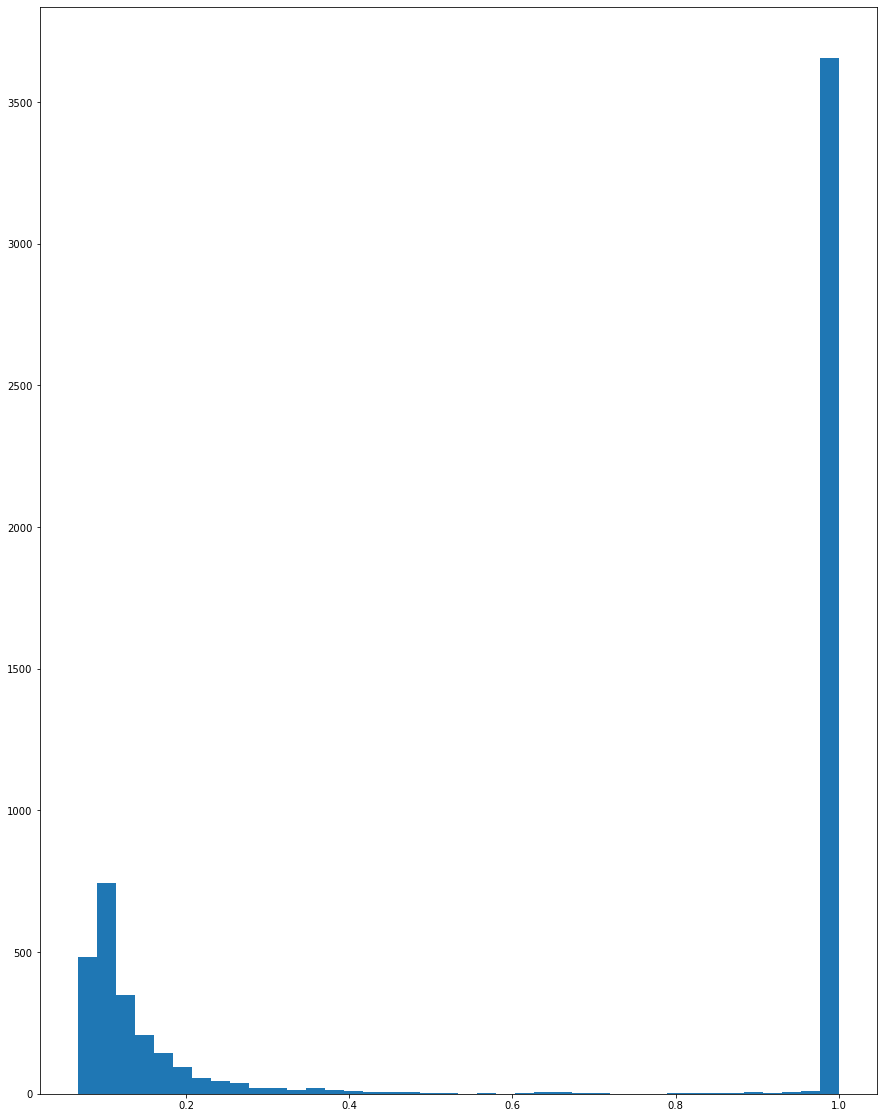

In [57]:
plt.figure(figsize=(15,20))
plt.hist(binary.pred_type, bins=40)
plt.show()

In [11]:
binary[binary.pred_type<=0.2]

,img_path,pred_type
0,test_data/1.png,0.113235
1,test_data/2.png,0.135533
2,test_data/3.png,0.080725
5,test_data/6.png,0.134040
8,test_data/9.png,0.123678
...,...,...
5981,test_data/5982.png,0.099268
5988,test_data/5989.png,0.081798
5990,test_data/5991.png,0.151910
5992,test_data/5993.png,0.112496


In [14]:
binary.loc[binary.pred_type<0.2, 'pred_type'] = 0
binary.loc[binary.pred_type>=0.2, 'pred_type'] = 1

binary

/opt/homebrew/Caskroom/miniforge/base/envs/m1/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,img_path,pred_type
0,test_data/1.png,0.0
1,test_data/2.png,0.0
2,test_data/3.png,0.0
3,test_data/4.png,1.0
4,test_data/5.png,1.0
...,...,...
5995,test_data/5996.png,1.0
5996,test_data/5997.png,1.0
5997,test_data/5998.png,1.0
5998,test_data/5999.png,1.0


In [13]:
binary.describe()

,pred_type
count,6000.000000
mean,0.667833
std,0.471030
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [15]:
test_1class = binary[binary.pred_type==0][['img_path']]
test_1class

,img_path
0,test_data/1.png
1,test_data/2.png
2,test_data/3.png
5,test_data/6.png
8,test_data/9.png
...,...
5981,test_data/5982.png
5988,test_data/5989.png
5990,test_data/5991.png
5992,test_data/5993.png


In [16]:
test_1class.to_csv('test_1class.csv', index=False)

In [15]:
test_2class = binary[binary.pred_type==1][['img_path']]
test_2class

,img_path
3,test_data/4.png
4,test_data/5.png
6,test_data/7.png
7,test_data/8.png
9,test_data/10.png
...,...
5994,test_data/5995.png
5995,test_data/5996.png
5996,test_data/5997.png
5997,test_data/5998.png


In [16]:
test_2class['pred'] = test_2class.img_path.apply(count_sq, args=(bord,))

test_data/4.png
test_data/5.png
test_data/7.png
test_data/8.png
test_data/10.png
test_data/13.png
test_data/14.png
test_data/16.png
test_data/18.png
test_data/19.png
test_data/20.png
test_data/22.png
test_data/23.png
test_data/24.png
test_data/25.png
test_data/26.png
test_data/27.png
test_data/28.png
test_data/29.png
test_data/31.png
test_data/32.png
test_data/33.png
test_data/34.png
test_data/35.png
test_data/36.png
test_data/39.png
test_data/40.png
test_data/41.png
test_data/43.png
test_data/44.png
test_data/45.png
test_data/48.png
test_data/49.png
test_data/50.png
test_data/51.png
test_data/53.png
test_data/55.png
test_data/56.png
test_data/57.png
test_data/58.png
test_data/60.png
test_data/61.png
test_data/62.png
test_data/63.png
test_data/64.png
test_data/65.png
test_data/66.png
test_data/69.png
test_data/70.png
test_data/71.png
test_data/72.png
test_data/74.png
test_data/75.png
test_data/80.png
test_data/82.png
test_data/83.png
test_data/84.png
test_data/85.png
test_data/86.png
t

In [17]:
test_2class

,img_path,pred
3,test_data/4.png,7
4,test_data/5.png,9
6,test_data/7.png,14
7,test_data/8.png,17
9,test_data/10.png,2
...,...,...
5994,test_data/5995.png,13
5995,test_data/5996.png,15
5996,test_data/5997.png,13
5997,test_data/5998.png,15


In [ ]:
test_2class

In [18]:
pred_1class = pd.read_csv('./predictions/by_part/1class.csv')
pred_1class

,img_path,label,type,pred
0,test_data/1.png,NaN,NaN,7
1,test_data/2.png,NaN,NaN,16
2,test_data/3.png,NaN,NaN,2
3,test_data/6.png,NaN,NaN,4
4,test_data/9.png,NaN,NaN,10
...,...,...,...,...
1988,test_data/5982.png,NaN,NaN,7
1989,test_data/5989.png,NaN,NaN,3
1990,test_data/5991.png,NaN,NaN,10
1991,test_data/5993.png,NaN,NaN,7


In [46]:
pd.set_option('display.max_rows', 100)

In [19]:
pred_1class = pred_1class[['img_path', 'pred']]
pred_1class

,img_path,pred
0,test_data/1.png,7
1,test_data/2.png,16
2,test_data/3.png,2
3,test_data/6.png,4
4,test_data/9.png,10
...,...,...
1988,test_data/5982.png,7
1989,test_data/5989.png,3
1990,test_data/5991.png,10
1991,test_data/5993.png,7


In [51]:
pred_1class[-15:]

,img_path,pred
1978,test_data/5954.png,5
1979,test_data/5957.png,2
1980,test_data/5963.png,3
1981,test_data/5964.png,7
1982,test_data/5966.png,4
1983,test_data/5967.png,1
1984,test_data/5968.png,20
1985,test_data/5975.png,8
1986,test_data/5978.png,16
1987,test_data/5981.png,3


In [22]:
pred_all = pd.concat((pred_1class, test_2class))
pred_all

,img_path,pred
0,test_data/1.png,7
1,test_data/2.png,16
2,test_data/3.png,2
3,test_data/6.png,4
4,test_data/9.png,10
...,...,...
5994,test_data/5995.png,13
5995,test_data/5996.png,15
5996,test_data/5997.png,13
5997,test_data/5998.png,15


In [23]:
pred_all = pred_all.sort_values('img_path')
pred_all

,img_path,pred
0,test_data/1.png,7
9,test_data/10.png,2
99,test_data/100.png,8
999,test_data/1000.png,5
1000,test_data/1001.png,3
...,...,...
994,test_data/995.png,8
995,test_data/996.png,2
329,test_data/997.png,6
997,test_data/998.png,8


In [24]:
pred_all.reset_index(inplace=True)

In [35]:
pred_all.img_path.str.split('/').str[1].str.split('.').str[0].astype('int')

0          1
1         10
2        100
3       1000
4       1001
        ... 
5995     995
5996     996
5997     997
5998     998
5999     999
Name: img_path, Length: 6000, dtype: int64

In [37]:
pred_all['ind'] = pred_all.img_path.str.split('/').str[1].str.split('.').str[0].astype('int')
pred_all

,index,img_path,pred,ind
0,0,test_data/1.png,7,1
1,9,test_data/10.png,2,10
2,99,test_data/100.png,8,100
3,999,test_data/1000.png,5,1000
4,1000,test_data/1001.png,3,1001
...,...,...,...,...
5995,994,test_data/995.png,8,995
5996,995,test_data/996.png,2,996
5997,329,test_data/997.png,6,997
5998,997,test_data/998.png,8,998


In [38]:
pred_all = pred_all.sort_values('ind')
pred_all

,index,img_path,pred,ind
0,0,test_data/1.png,7,1
1111,1,test_data/2.png,16,2
2222,2,test_data/3.png,2,3
3333,3,test_data/4.png,7,4
4444,4,test_data/5.png,9,5
...,...,...,...,...
5551,5995,test_data/5996.png,15,5996
5552,5996,test_data/5997.png,13,5997
5553,5997,test_data/5998.png,15,5998
5554,5998,test_data/5999.png,8,5999


In [40]:
pred_all[pred_all.pred>15]

,index,img_path,pred,ind
1111,1,test_data/2.png,16,2
5778,7,test_data/8.png,17,8
889,17,test_data/18.png,18,18
1223,9,test_data/21.png,19,21
1889,26,test_data/27.png,16,27
...,...,...,...,...
5509,5957,test_data/5958.png,16,5958
5520,1984,test_data/5968.png,20,5968
5524,5970,test_data/5971.png,18,5971
5531,1986,test_data/5978.png,16,5978


In [41]:
pred_all = pred_all[['pred']]
pred_all

,pred
0,7
1111,16
2222,2
3333,7
4444,9
...,...
5551,15
5552,13
5553,15
5554,8


In [42]:
pred_to_csv(pred_all)

/opt/homebrew/Caskroom/miniforge/base/envs/m1/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [43]:
pred_all

,label
0,7
1111,16
2222,2
3333,7
4444,9
...,...
5551,15
5552,13
5553,15
5554,8


Выборочно проверим работу на тестовом наборе

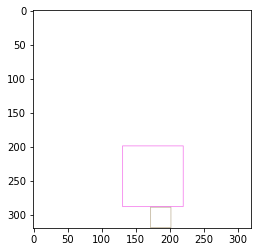

test_data/3.png


2    2
Name: img_path, dtype: int64

In [48]:
# откроем пример изображения
filename = '3.png' # Имя файла
image = Image.open('test_data/'+filename)
im_arr = np.array(image)
img1 = ImageDraw.Draw(image) 
plt.imshow(image) # Рисуем изображение
plt.show()

test.loc[2:2].img_path.apply(count_sq, args=(bord,))

**Результаты**:
- 0.38 rmse на обучающем наборе, 0.49 на тестовом

# Classification apply

чтобы немного улучшить результаты мы обучим классификатор, предскажем тип для каждого изображения на тестовом наборе и для каждого типа будем применять свои настройки подсчета квадратов

## Classification model

In [ ]:
from datetime import datetime
from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Activation,Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from PIL import Image #Для отрисовки изображений
%matplotlib inline

In [ ]:
train_path = None #Папка с папками картинок, рассортированных по категориям
batch_size = 25 #Размер выборки
img_width = 320 #Ширина изображения
img_height = 320 #Высота изображения

In [4]:
train['type'] = train['type'] - 1


In [5]:
train = pd.concat((train, pd.get_dummies(train['type'])), axis=1)

In [6]:
train

,img_path,label,type,0,1,2
0,train_data/1.png,3,0,1,0,0
1,train_data/2.png,7,2,0,0,1
2,train_data/3.png,9,1,0,1,0
3,train_data/4.png,9,0,1,0,0
4,train_data/5.png,10,0,1,0,0
...,...,...,...,...,...,...
2995,train_data/2996.png,10,0,1,0,0
2996,train_data/2997.png,2,0,1,0,0
2997,train_data/2998.png,7,0,1,0,0
2998,train_data/2999.png,7,2,0,0,1


In [7]:
#Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, #Значения цвета меняем на дробные показания
    
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, # Включаем отзеркаливание изображений
    vertical_flip=True,
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.1 #Указываем разделение изображений на обучающую и тестовую выборку
)

In [8]:
# обучающая выборка
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = 'img_path',
    y_col = [0,1,2],
    color_mode = 'rgb',
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='raw',
    shuffle=True, #Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
validation_generator =  datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = 'img_path',
    y_col = [0,1,2],
    color_mode = 'rgb',
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='raw',
    shuffle=True, #Перемешивание выборки
    subset='validation' # устанавливаем как набор для обучения
)

Found 2700 validated image filenames.
Found 300 validated image filenames.


In [9]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Третий сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Четвертый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Пятый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(2048, activation='relu'))
#Полносвязный слой
model.add(Dense(4096, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

2022-08-20 14:09:47.996110: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-20 14:09:47.996818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-20 14:09:48.037363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 14:09:48.037840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-08-20 14:09:48.037862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-20 14:09:48.039867: I tensorflow/stream_executor/platf

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=300,
    verbose=1
)

Epoch 1/300
 20/108 [====>.........................] - ETA: 32s - loss: 0.6077 - accuracy: 0.6500

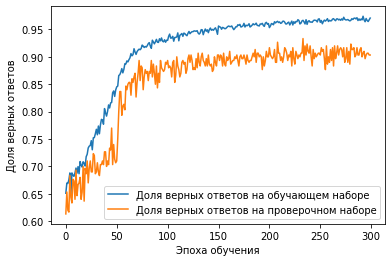

In [13]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [16]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'img_path',
    color_mode = 'rgb',
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode=None, #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=False, #Перемешивание выборки
)

Found 6000 validated image filenames.


In [17]:
test_generator.reset()

In [18]:
pred_classes=model.predict_generator(test_generator,
verbose=1)

/home/prop/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


240/240 [==============================] - 88s 367ms/step


In [19]:
pred_classes

array([[9.8237956e-01, 1.6192570e-02, 1.4279266e-03],
       [9.1457242e-01, 8.5409433e-02, 1.8211498e-05],
       [9.7996831e-01, 1.6052667e-02, 3.9790794e-03],
       ...,
       [2.7982674e-07, 9.2963573e-06, 9.9999046e-01],
       [6.2727947e-09, 9.9996293e-01, 3.7080681e-05],
       [1.4859249e-02, 2.4974399e-06, 9.8513830e-01]], dtype=float32)

# Three classes

Разобъем тестовый набор на поднаборы по предсказанным типам изображений.

Каждому поднабору применим свои настройки

In [6]:
test['class_1'] = pred_classes[:,0]
test

,img_path,class_1
0,test_data/1.png,9.823796e-01
1,test_data/2.png,9.145724e-01
2,test_data/3.png,9.799683e-01
3,test_data/4.png,3.285581e-12
4,test_data/5.png,3.736210e-09
...,...,...
5995,test_data/5996.png,0.000000e+00
5996,test_data/5997.png,0.000000e+00
5997,test_data/5998.png,2.798267e-07
5998,test_data/5999.png,6.272795e-09


In [7]:
test['class_2'] = pred_classes[:,1]
test

,img_path,class_1,class_2
0,test_data/1.png,9.823796e-01,0.016193
1,test_data/2.png,9.145724e-01,0.085409
2,test_data/3.png,9.799683e-01,0.016053
3,test_data/4.png,3.285581e-12,0.000006
4,test_data/5.png,3.736210e-09,0.999706
...,...,...,...
5995,test_data/5996.png,0.000000e+00,0.000000
5996,test_data/5997.png,0.000000e+00,0.000000
5997,test_data/5998.png,2.798267e-07,0.000009
5998,test_data/5999.png,6.272795e-09,0.999963


In [8]:
test['class_3'] = pred_classes[:,2]
test

,img_path,class_1,class_2,class_3
0,test_data/1.png,9.823796e-01,0.016193,0.001428
1,test_data/2.png,9.145724e-01,0.085409,0.000018
2,test_data/3.png,9.799683e-01,0.016053,0.003979
3,test_data/4.png,3.285581e-12,0.000006,0.999993
4,test_data/5.png,3.736210e-09,0.999706,0.000294
...,...,...,...,...
5995,test_data/5996.png,0.000000e+00,0.000000,1.000000
5996,test_data/5997.png,0.000000e+00,0.000000,1.000000
5997,test_data/5998.png,2.798267e-07,0.000009,0.999990
5998,test_data/5999.png,6.272795e-09,0.999963,0.000037


<AxesSubplot:>

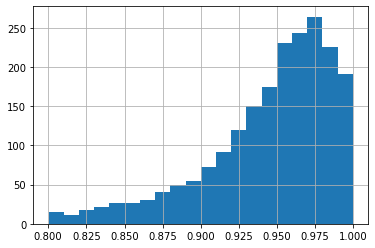

In [34]:
test.class_1[test.class_1>0.8].hist(bins=20)

## Type 1

In [10]:
test

,img_path,class_1,class_2,class_3
0,test_data/1.png,9.823796e-01,0.016193,0.001428
1,test_data/2.png,9.145724e-01,0.085409,0.000018
2,test_data/3.png,9.799683e-01,0.016053,0.003979
3,test_data/4.png,3.285581e-12,0.000006,0.999993
4,test_data/5.png,3.736210e-09,0.999706,0.000294
...,...,...,...,...
5995,test_data/5996.png,0.000000e+00,0.000000,1.000000
5996,test_data/5997.png,0.000000e+00,0.000000,1.000000
5997,test_data/5998.png,2.798267e-07,0.000009,0.999990
5998,test_data/5999.png,6.272795e-09,0.999963,0.000037


In [13]:
test['class_full'] = np.argmax(pred_classes, axis=1)

In [14]:
test

,img_path,class_1,class_2,class_3,class_full
0,test_data/1.png,9.823796e-01,0.016193,0.001428,0
1,test_data/2.png,9.145724e-01,0.085409,0.000018,0
2,test_data/3.png,9.799683e-01,0.016053,0.003979,0
3,test_data/4.png,3.285581e-12,0.000006,0.999993,2
4,test_data/5.png,3.736210e-09,0.999706,0.000294,1
...,...,...,...,...,...
5995,test_data/5996.png,0.000000e+00,0.000000,1.000000,2
5996,test_data/5997.png,0.000000e+00,0.000000,1.000000,2
5997,test_data/5998.png,2.798267e-07,0.000009,0.999990,2
5998,test_data/5999.png,6.272795e-09,0.999963,0.000037,1


In [15]:
test_1 = test[test.class_full==0]
test_1

,img_path,class_1,class_2,class_3,class_full
0,test_data/1.png,0.982380,0.016193,1.427927e-03,0
1,test_data/2.png,0.914572,0.085409,1.821150e-05,0
2,test_data/3.png,0.979968,0.016053,3.979079e-03,0
5,test_data/6.png,0.886614,0.108727,4.659219e-03,0
8,test_data/9.png,0.983413,0.013655,2.932713e-03,0
...,...,...,...,...,...
5981,test_data/5982.png,0.982809,0.016984,2.062971e-04,0
5985,test_data/5986.png,0.975919,0.024080,7.001373e-07,0
5988,test_data/5989.png,0.990947,0.002783,6.269257e-03,0
5990,test_data/5991.png,0.959962,0.035575,4.462739e-03,0


In [ ]:
# bord 10, bordsq 3 2,(2,2)
bord = 10
bord_square = 3
its = 2
its_size = (2,2)
big_bord = 3
test_1['pred'] = test_1.img_path.apply(count_sq, args=(bord,))

## Type 2

In [25]:
test_2 = test[test.class_full==1]
test_2

,img_path,class_1,class_2,class_3,class_full
4,test_data/5.png,3.736210e-09,0.999706,0.000294,1
7,test_data/8.png,8.567202e-06,0.999727,0.000264,1
12,test_data/13.png,4.090859e-09,0.999988,0.000012,1
13,test_data/14.png,9.510909e-09,0.999984,0.000016,1
15,test_data/16.png,7.267500e-09,0.998886,0.001114,1
...,...,...,...,...,...
5984,test_data/5985.png,3.165281e-10,0.999326,0.000674,1
5986,test_data/5987.png,3.312181e-05,0.893725,0.106242,1
5989,test_data/5990.png,8.266927e-09,0.999892,0.000108,1
5994,test_data/5995.png,4.733783e-09,0.999994,0.000006,1


In [ ]:
# bord 3, bordsq = 2, 2,(1,1)

bord = 3
bord_square = 2
its = 2
its_size = (1,1)
big_bord = 3
test_2['pred'] = test_2.img_path.apply(count_sq, args=(bord,))

In [27]:
test_2

,img_path,class_1,class_2,class_3,class_full,pred
4,test_data/5.png,3.736210e-09,0.999706,0.000294,1,9
7,test_data/8.png,8.567202e-06,0.999727,0.000264,1,18
12,test_data/13.png,4.090859e-09,0.999988,0.000012,1,6
13,test_data/14.png,9.510909e-09,0.999984,0.000016,1,14
15,test_data/16.png,7.267500e-09,0.998886,0.001114,1,4
...,...,...,...,...,...,...
5984,test_data/5985.png,3.165281e-10,0.999326,0.000674,1,8
5986,test_data/5987.png,3.312181e-05,0.893725,0.106242,1,2
5989,test_data/5990.png,8.266927e-09,0.999892,0.000108,1,4
5994,test_data/5995.png,4.733783e-09,0.999994,0.000006,1,14


## Type 3

In [28]:
test_3 = test[test.class_full==2]
test_3

,img_path,class_1,class_2,class_3,class_full
3,test_data/4.png,3.285581e-12,6.499486e-06,0.999993,2
6,test_data/7.png,0.000000e+00,0.000000e+00,1.000000,2
9,test_data/10.png,7.945125e-07,1.548239e-01,0.845175,2
18,test_data/19.png,7.575534e-06,1.717444e-04,0.999821,2
21,test_data/22.png,5.459316e-36,0.000000e+00,1.000000,2
...,...,...,...,...,...
5992,test_data/5993.png,2.983662e-29,3.966050e-35,1.000000,2
5995,test_data/5996.png,0.000000e+00,0.000000e+00,1.000000,2
5996,test_data/5997.png,0.000000e+00,0.000000e+00,1.000000,2
5997,test_data/5998.png,2.798267e-07,9.296357e-06,0.999990,2


In [ ]:
# bord 10, bordsq = 2, 2,(2,2)

bord = 10
bord_square = 2
its = 2
its_size = (2,2)
big_bord = 3
test_3['pred'] = test_3.img_path.apply(count_sq, args=(bord,))

In [79]:
test

,img_path
0,test_data/1.png
1,test_data/2.png
2,test_data/3.png
3,test_data/4.png
4,test_data/5.png
...,...
5995,test_data/5996.png
5996,test_data/5997.png
5997,test_data/5998.png
5998,test_data/5999.png


## Union all subsets

In [30]:
test = test.merge(test_1[['img_path','pred']], on='img_path', how='left')

In [31]:
test = test.merge(test_2[['img_path','pred']], on='img_path', how='left')

In [32]:
test = test.merge(test_3[['img_path','pred']], on='img_path', how='left')

In [83]:
test

,img_path,pred_x,pred_y,pred
0,test_data/1.png,7.0,NaN,NaN
1,test_data/2.png,16.0,NaN,NaN
2,test_data/3.png,2.0,NaN,NaN
3,test_data/4.png,NaN,NaN,6.0
4,test_data/5.png,NaN,9.0,NaN
...,...,...,...,...
5995,test_data/5996.png,NaN,NaN,15.0
5996,test_data/5997.png,NaN,NaN,14.0
5997,test_data/5998.png,NaN,NaN,16.0
5998,test_data/5999.png,NaN,8.0,NaN


In [ ]:
test[test.pred.isna() & test.pred_x.isna() & test.pred_y.isna() & test.pred_last.isna()]

,img_path,pred_x,pred_y,pred,pred_last


In [33]:
test.fillna(0, inplace=True)
test

,img_path,class_1,class_2,class_3,class_full,pred_x,pred_y,pred
0,test_data/1.png,9.823796e-01,0.016193,0.001428,0,7.0,0.0,0.0
1,test_data/2.png,9.145724e-01,0.085409,0.000018,0,16.0,0.0,0.0
2,test_data/3.png,9.799683e-01,0.016053,0.003979,0,2.0,0.0,0.0
3,test_data/4.png,3.285581e-12,0.000006,0.999993,2,0.0,0.0,6.0
4,test_data/5.png,3.736210e-09,0.999706,0.000294,1,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...
5995,test_data/5996.png,0.000000e+00,0.000000,1.000000,2,0.0,0.0,15.0
5996,test_data/5997.png,0.000000e+00,0.000000,1.000000,2,0.0,0.0,14.0
5997,test_data/5998.png,2.798267e-07,0.000009,0.999990,2,0.0,0.0,16.0
5998,test_data/5999.png,6.272795e-09,0.999963,0.000037,1,0.0,8.0,0.0


In [34]:
test['pred_full'] = test.pred+test.pred_x + test.pred_y
test

,img_path,class_1,class_2,class_3,class_full,pred_x,pred_y,pred,pred_full
0,test_data/1.png,9.823796e-01,0.016193,0.001428,0,7.0,0.0,0.0,7.0
1,test_data/2.png,9.145724e-01,0.085409,0.000018,0,16.0,0.0,0.0,16.0
2,test_data/3.png,9.799683e-01,0.016053,0.003979,0,2.0,0.0,0.0,2.0
3,test_data/4.png,3.285581e-12,0.000006,0.999993,2,0.0,0.0,6.0,6.0
4,test_data/5.png,3.736210e-09,0.999706,0.000294,1,0.0,9.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...
5995,test_data/5996.png,0.000000e+00,0.000000,1.000000,2,0.0,0.0,15.0,15.0
5996,test_data/5997.png,0.000000e+00,0.000000,1.000000,2,0.0,0.0,14.0,14.0
5997,test_data/5998.png,2.798267e-07,0.000009,0.999990,2,0.0,0.0,16.0,16.0
5998,test_data/5999.png,6.272795e-09,0.999963,0.000037,1,0.0,8.0,0.0,8.0


In [35]:
test_itog = test[['img_path', 'pred_full']]
test_itog.rename(columns={'pred_full': 'pred'}, inplace=True)
test_itog

/tmp/ipykernel_4750/655365359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_itog.rename(columns={'pred_full': 'pred'}, inplace=True)


,img_path,pred
0,test_data/1.png,7.0
1,test_data/2.png,16.0
2,test_data/3.png,2.0
3,test_data/4.png,6.0
4,test_data/5.png,9.0
...,...,...
5995,test_data/5996.png,15.0
5996,test_data/5997.png,14.0
5997,test_data/5998.png,16.0
5998,test_data/5999.png,8.0


In [36]:
pred_to_csv(test_itog)

/tmp/ipykernel_4750/3991628192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred.rename(columns={'pred': 'label'}, inplace=True)


Итого после применения разных настроек к разным предсказанным типам изображений удалось снизить ошибку rmse с 0.4963197893831489 до 0.42504901678120216

# Conclusion

Итого была достигнута примелимая точность на тестовом наборе. При этом она не зависит от того, как данные были поделены на тестовый и обучающий наборы. Напомню, что скорее всего тестовый набор специально содержит большшее количество квадратов на каждом изображении по сравнению с обучающим, что сбивает модели M. Данный подход не зависит от ML и дает достатточно точное предсказание

Итоговая ошибка rmse:
Public  0.42504901678120216
Private  0.4127145906474998